In [12]:
import pandas as pd
import matplotlib.pyplot as plt
from math import pi
%matplotlib inline

def interperate_vision_model(settings={}):
    from spacr.io import _read_and_merge_data, _results_to_csv
    from spacr.plot import plot_image_mask_overlay, _plot_controls, _plot_recruitment
    from spacr.utils import _object_filter, annotate_conditions, _calculate_recruitment, _group_by_well, save_settings
    from spacr.settings import get_analyze_recruitment_default_settings
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.inspection import permutation_importance
    import shap
    
    # Function to create radar plot for individual and combined values
    def create_extended_radar_plot(values, labels, title):
        values = list(values) + [values[0]]  # Close the loop for radar chart
        angles = [n / float(len(labels)) * 2 * pi for n in range(len(labels))]
        angles += angles[:1]

        fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
        ax.plot(angles, values, linewidth=2, linestyle='solid')
        ax.fill(angles, values, alpha=0.25)

        ax.set_xticks(angles[:-1])
        ax.set_xticklabels(labels, fontsize=10, rotation=45, ha='right')
        plt.title(title, pad=20)
        plt.show()

    def extract_compartment_channel(feature_name):
        # Identify compartment as the first part before an underscore
        compartment = feature_name.split('_')[0]
        
        if compartment == 'cells':
            compartment = 'metadata'

        # Identify channels based on substring presence
        channels = []
        if 'channel_0' in feature_name:
            channels.append('channel_0')
        if 'channel_1' in feature_name:
            channels.append('channel_1')
        if 'channel_2' in feature_name:
            channels.append('channel_2')
        if 'channel_3' in feature_name:
            channels.append('channel_3')

        # If multiple channels are found, join them with a '+'
        if channels:
            channel = ' + '.join(channels)
        else:
            channel = 'morphology'  # Use 'morphology' if no channel identifier is found

        return (compartment, channel)

    def read_and_preprocess_data(settings):

        df, _ = _read_and_merge_data(
            locs=[settings['src']+'/measurements/measurements.db'], 
            tables=settings['tables'], 
            verbose=True, 
            nuclei_limit=settings['nuclei_limit'], 
            pathogen_limit=settings['pathogen_limit']
        )

        scores_df = pd.read_csv(settings['scores'])

        # Clean and align columns for merging
        df['object_label'] = df['object_label'].str.replace('o', '')

        if 'row_name' not in scores_df.columns:
            scores_df['row_name'] = scores_df['row']

        if 'column_name' not in scores_df.columns:
            scores_df['column_name'] = scores_df['col']

        if 'object_label' not in scores_df.columns:
            scores_df['object_label'] = scores_df['object']

        # Remove the 'o' prefix from 'object_label' in df, ensuring it is a string type
        df['object_label'] = df['object_label'].str.replace('o', '').astype(str)

        # Ensure 'object_label' in scores_df is also a string
        scores_df['object_label'] = scores_df['object'].astype(str)

        # Ensure all join columns have the same data type in both DataFrames
        df[['plate', 'row_name', 'column_name', 'field', 'object_label']] = df[['plate', 'row_name', 'column_name', 'field', 'object_label']].astype(str)
        scores_df[['plate', 'row_name', 'column_name', 'field', 'object_label']] = scores_df[['plate', 'row_name', 'column_name', 'field', 'object_label']].astype(str)

        # Select only the necessary columns from scores_df for merging
        scores_df = scores_df[['plate', 'row_name', 'column_name', 'field', 'object_label', settings['score_column']]]

        # Now merge DataFrames
        merged_df = pd.merge(df, scores_df, on=['plate', 'row_name', 'column_name', 'field', 'object_label'], how='inner')

        # Separate numerical features and the score column
        X = merged_df.select_dtypes(include='number').drop(columns=[settings['score_column']])
        y = merged_df[settings['score_column']]

        return X, y, merged_df
    
    X, y, merged_df = read_and_preprocess_data(settings)
    
    # Step 1: Feature Importance using Random Forest
    if settings['feature_importance'] or settings['feature_importance']:
        model = RandomForestClassifier(random_state=42, n_jobs=settings['n_jobs'])
        model.fit(X, y)
        
        if settings['feature_importance']:
            print(f"Feature Importance ...")
            feature_importances = model.feature_importances_
            feature_importance_df = pd.DataFrame({'feature': X.columns, 'importance': feature_importances})
            feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)
            top_feature_importance_df = feature_importance_df.head(settings['top_features'])

            # Plot Feature Importance
            plt.figure(figsize=(10, 6))
            plt.barh(top_feature_importance_df['feature'], top_feature_importance_df['importance'])
            plt.xlabel('Importance')
            plt.title(f"Top {settings['top_features']} Features - Feature Importance")
            plt.gca().invert_yaxis()
            plt.show()
        
        if settings['save']:
            _results_to_csv(feature_importance_df, filename='feature_importance.csv')
    
    # Step 2: Permutation Importance
    if settings['permutation_importance']:
        print(f"Permutation Importance ...")
        perm_importance = permutation_importance(model, X, y, n_repeats=10, random_state=42, n_jobs=settings['n_jobs'])
        perm_importance_df = pd.DataFrame({'feature': X.columns, 'importance': perm_importance.importances_mean})
        perm_importance_df = perm_importance_df.sort_values(by='importance', ascending=False)
        top_perm_importance_df = perm_importance_df.head(settings['top_features'])

        # Plot Permutation Importance
        plt.figure(figsize=(10, 6))
        plt.barh(top_perm_importance_df['feature'], top_perm_importance_df['importance'])
        plt.xlabel('Importance')
        plt.title(f"Top {settings['top_features']} Features - Permutation Importance")
        plt.gca().invert_yaxis()
        plt.show()
        
        if settings['save']:
            _results_to_csv(perm_importance_df, filename='permutation_importance.csv')
    
    # Step 3: SHAP Analysis
    if settings['shap']:
        print(f"SHAP Analysis ...")

        # Select top N features based on Random Forest importance and fit the model on these features only
        top_features = feature_importance_df.head(settings['top_features'])['feature']
        X_top = X[top_features]

        # Refit the model on this subset of features
        model = RandomForestClassifier(random_state=42, n_jobs=settings['n_jobs'])
        model.fit(X_top, y)

        # Sample a smaller subset of rows to speed up SHAP
        if settings['shap_sample']:
            sample = int(len(X_top) / 100)
            X_sample = X_top.sample(min(sample, len(X_top)), random_state=42)
        else:
            X_sample = X_top

        # Initialize SHAP explainer with the same subset of features
        explainer = shap.Explainer(model.predict, X_sample)
        shap_values = explainer(X_sample, max_evals=1500)

        # Plot SHAP summary for the selected sample and top features
        shap.summary_plot(shap_values, X_sample, max_display=settings['top_features'])

        # Convert SHAP values to a DataFrame for easier manipulation
        shap_df = pd.DataFrame(shap_values.values, columns=X_sample.columns)
        
        # Apply the function to create MultiIndex columns with compartment and channel
        shap_df.columns = pd.MultiIndex.from_tuples(
            [extract_compartment_channel(feat) for feat in shap_df.columns], 
            names=['compartment', 'channel']
        )
        
        # Aggregate SHAP values by compartment and channel
        compartment_mean = shap_df.abs().groupby(level='compartment', axis=1).mean().mean(axis=0)
        channel_mean = shap_df.abs().groupby(level='channel', axis=1).mean().mean(axis=0)

        # Calculate combined importance for each pair of compartments and channels
        combined_compartment = {}
        for i, comp1 in enumerate(compartment_mean.index):
            for comp2 in compartment_mean.index[i+1:]:
                combined_compartment[f"{comp1} + {comp2}"] = shap_df.loc[:, (comp1, slice(None))].abs().mean().mean() + \
                                                              shap_df.loc[:, (comp2, slice(None))].abs().mean().mean()
        
        combined_channel = {}
        for i, chan1 in enumerate(channel_mean.index):
            for chan2 in channel_mean.index[i+1:]:
                combined_channel[f"{chan1} + {chan2}"] = shap_df.loc[:, (slice(None), chan1)].abs().mean().mean() + \
                                                          shap_df.loc[:, (slice(None), chan2)].abs().mean().mean()

        # Prepare values and labels for radar charts
        all_compartment_importance = list(compartment_mean.values) + list(combined_compartment.values())
        all_compartment_labels = list(compartment_mean.index) + list(combined_compartment.keys())

        all_channel_importance = list(channel_mean.values) + list(combined_channel.values())
        all_channel_labels = list(channel_mean.index) + list(combined_channel.keys())

        # Create radar plots for compartments and channels
        create_extended_radar_plot(all_compartment_importance, all_compartment_labels, "SHAP Importance by Compartment (Individual and Combined)")
        create_extended_radar_plot(all_channel_importance, all_channel_labels, "SHAP Importance by Channel (Individual and Combined)")
    
    return merged_df

plate: 1 cells:60816
plate: 1 nucleus:80889 
plate: 1 pathogens:111317
plate: 1 cytoplasms: 60816
cells: 60816
cells grouped: 60816
cytoplasms: 60816
cytoplasms grouped: 60816
nucleus: 80889
nucleus grouped: 60816
afer multiinfected Float: 111317
pathogens: 111317
pathogens grouped: 60816
Generated dataframe with: 781 columns and 60816 rows
Feature Importance ...


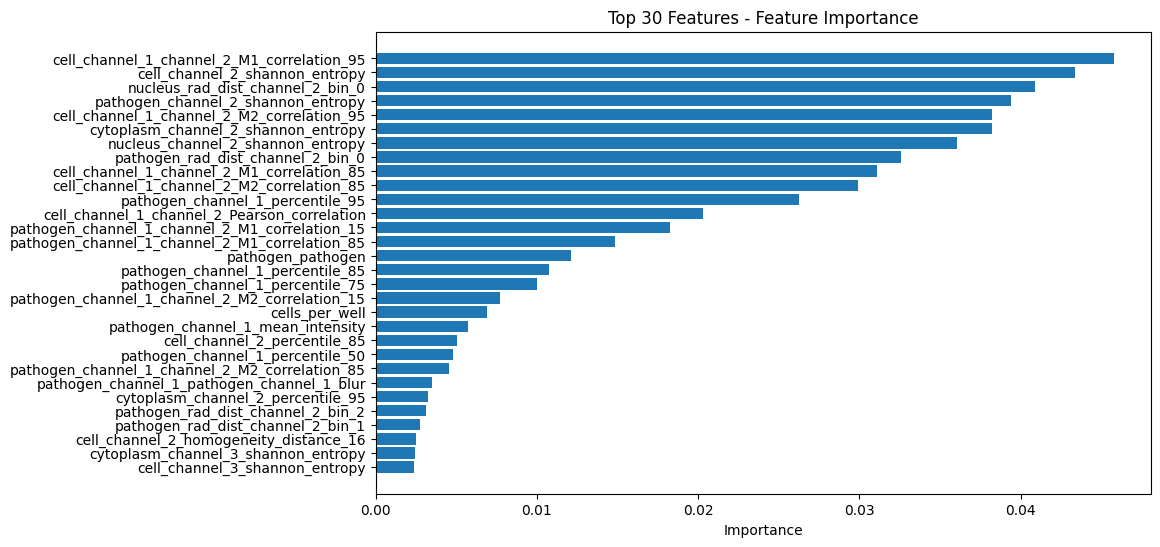

SHAP Analysis ...


PermutationExplainer explainer: 609it [03:59,  2.43it/s]                                                                            


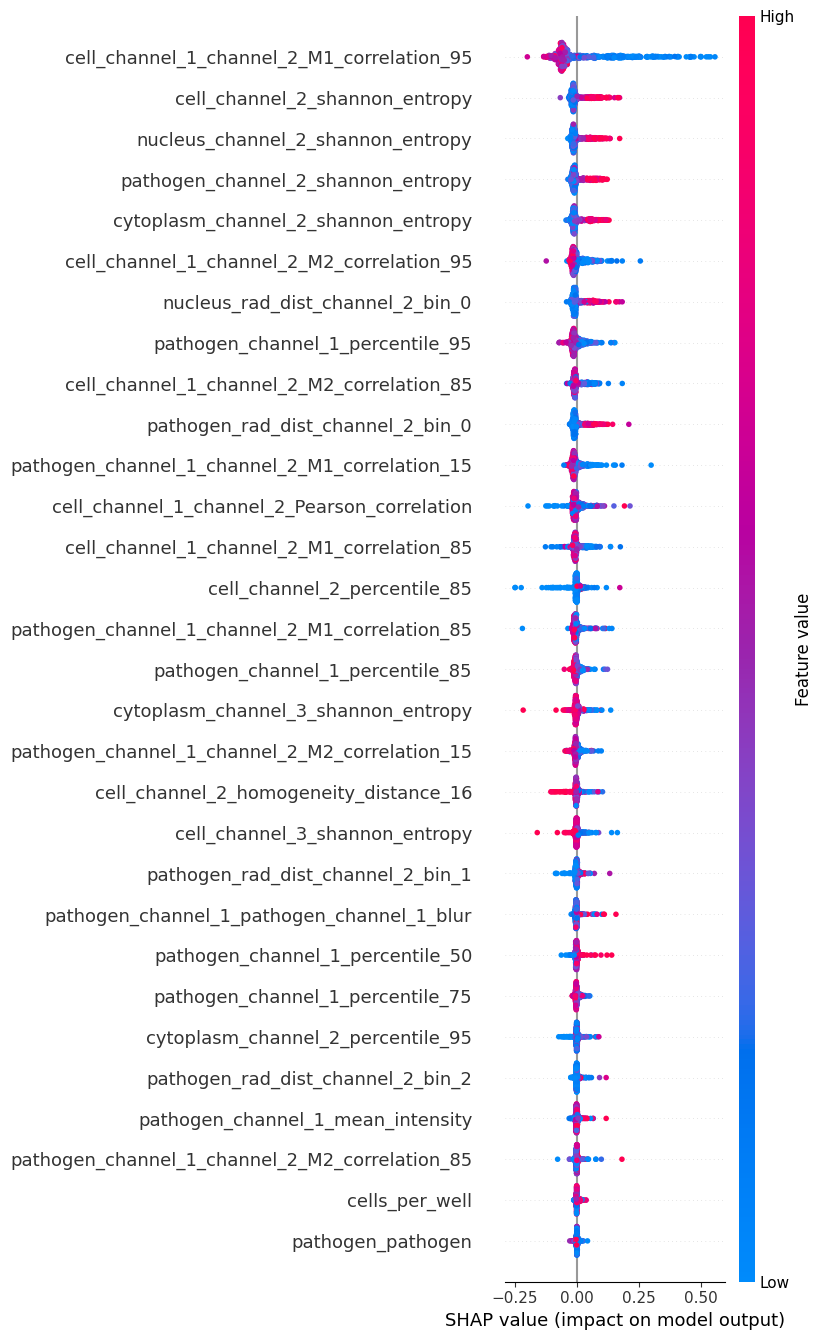

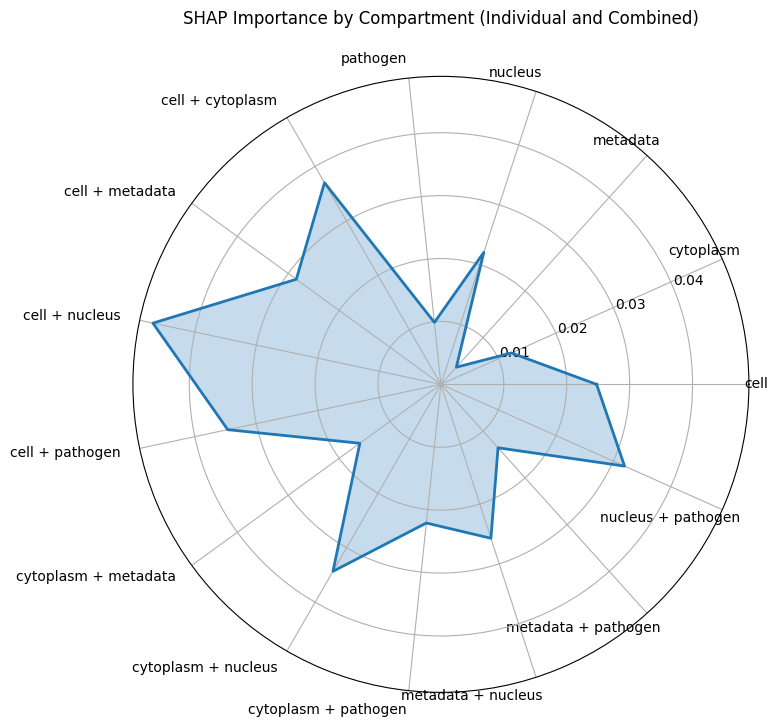

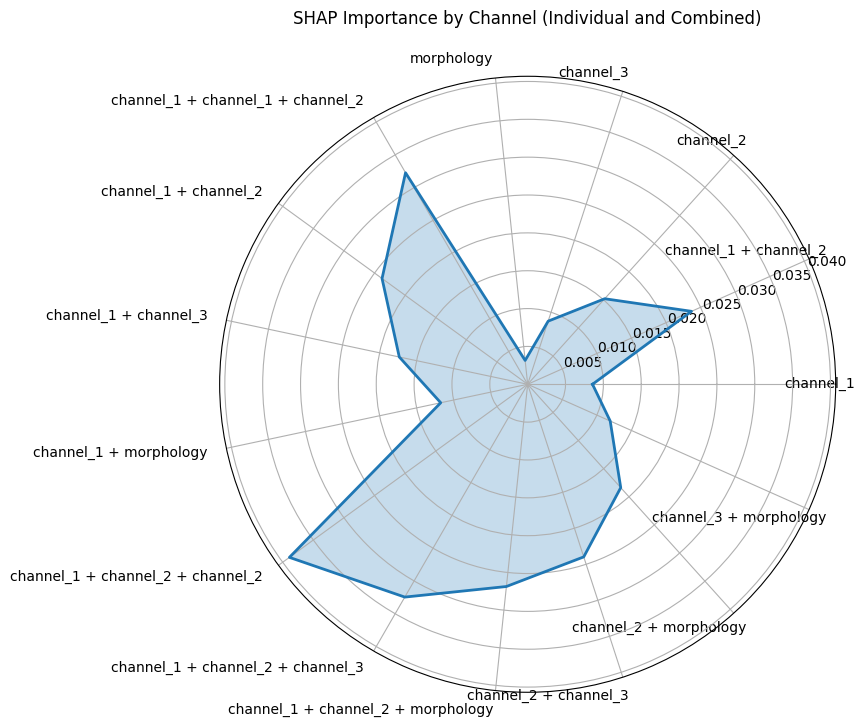

,object_label,plate,row_name,column_name,field,prcf,file_name,path_name,label_list_morphology,label_list_intensity,...,pathogen_channel_1_channel_3_M1_correlation_95,pathogen_channel_1_channel_3_M2_correlation_95,pathogen_channel_2_channel_3_M1_correlation_15,pathogen_channel_2_channel_3_M2_correlation_15,pathogen_channel_2_channel_3_M1_correlation_85,pathogen_channel_2_channel_3_M2_correlation_85,pathogen_channel_2_channel_3_M1_correlation_95,pathogen_channel_2_channel_3_M2_correlation_95,pathogen_prcfo_count,cv_predictions
0,101,pplate1,r10,c11,f10,pplate1_r10_c11_f10,plate1_J11_10,/nas_mnt/carruthers/Einar/tsg101_screen/TSG101...,[101],"[101, 101, 101, 101, 101, 101, 101, 101, 101, ...",...,0.000000,0.000000,0.700896,0.721041,0.000000,0.000000,0.000000,0.000000,1.0,0
1,104,pplate1,r10,c11,f10,pplate1_r10_c11_f10,plate1_J11_10,/nas_mnt/carruthers/Einar/tsg101_screen/TSG101...,[104],"[104, 104, 104, 104, 104, 104, 104, 104, 104, ...",...,0.002224,0.001375,0.781562,0.751003,0.025694,0.020279,0.000470,0.000349,1.0,0
2,107,pplate1,r10,c11,f10,pplate1_r10_c11_f10,plate1_J11_10,/nas_mnt/carruthers/Einar/tsg101_screen/TSG101...,[107],"[107, 107, 107, 107, 107, 107, 107, 107, 107, ...",...,0.004971,0.003943,0.824009,0.766166,0.029448,0.020089,0.009793,0.006330,1.0,0
3,137,pplate1,r10,c11,f10,pplate1_r10_c11_f10,plate1_J11_10,/nas_mnt/carruthers/Einar/tsg101_screen/TSG101...,[137],"[137, 137, 137, 137, 137, 137, 137, 137, 137, ...",...,0.000000,0.000000,0.756574,0.729944,0.027023,0.020488,0.000000,0.000000,1.0,0
4,138,pplate1,r10,c11,f10,pplate1_r10_c11_f10,plate1_J11_10,/nas_mnt/carruthers/Einar/tsg101_screen/TSG101...,[138],"[138, 138, 138, 138, 138, 138, 138, 138, 138, ...",...,0.000000,0.000000,0.826501,0.770436,0.073517,0.049407,0.012787,0.008092,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60811,4,pplate1,r9,c9,f9,pplate1_r9_c9_f9,plate1_I09_9,/nas_mnt/carruthers/Einar/tsg101_screen/TSG101...,[4],"[4, 4, 4, 4, 4, 4, 4, 4, 4, 4]",...,0.000662,0.000584,0.833220,0.781898,0.039290,0.022536,0.003286,0.001328,2.0,1
60812,73,pplate1,r9,c9,f9,pplate1_r9_c9_f9,plate1_I09_9,/nas_mnt/carruthers/Einar/tsg101_screen/TSG101...,[73],"[73, 73, 73, 73, 73, 73, 73, 73, 73, 73]",...,0.000000,0.000000,0.746353,0.777684,0.027406,0.025505,0.001731,0.000656,1.0,0
60813,75,pplate1,r9,c9,f9,pplate1_r9_c9_f9,plate1_I09_9,/nas_mnt/carruthers/Einar/tsg101_screen/TSG101...,[75],"[75, 75, 75, 75, 75, 75, 75, 75, 75, 75]",...,0.000313,0.000329,0.735061,0.736596,0.028893,0.022633,0.004980,0.003748,2.0,0
60814,79,pplate1,r9,c9,f9,pplate1_r9_c9_f9,plate1_I09_9,/nas_mnt/carruthers/Einar/tsg101_screen/TSG101...,[79],"[79, 79, 79, 79, 79, 79, 79, 79, 79, 79]",...,0.000000,0.000000,0.740277,0.732288,0.001253,0.000906,0.000000,0.000000,1.0,0


In [13]:
settings = {'src':'/nas_mnt/carruthers/Einar/tsg101_screen/TSG101SCREEN_20240810_132824/plate1',
           'scores':'/nas_mnt/carruthers/Einar/tsg101_screen/TSG101SCREEN_20240810_132824/plate1/datasets/241007_241003_tsg101_screen_plate1_maxvit_t_epoch_99_acc_99.0_channels_rgb_result.csv',
           'tables':['cell', 'nucleus', 'pathogen','cytoplasm'],
           'feature_importance':True,
           'permutation_importance':False,
           'shap':True,
           'save':False,
           'nuclei_limit':1000,
           'pathogen_limit':1000,
           'top_features':30,
           'shap_sample':True,
           'n_jobs':-1,
           'shap_approximate':True,
           'score_column':'cv_predictions'}

merged_df = interperate_vision_model(settings)
display(merged_df)

In [15]:
for col in merged_df.columns:
    print(col)

object_label
plate
row_name
column_name
field
prcf
file_name
path_name
label_list_morphology
label_list_intensity
prc
cells_per_well
cell_area
cell_area_filled
cell_area_bbox
cell_convex_area
cell_major_axis_length
cell_minor_axis_length
cell_eccentricity
cell_solidity
cell_extent
cell_perimeter
cell_euler_number
cell_equivalent_diameter_area
cell_feret_diameter_max
cell_zernike_0
cell_zernike_1
cell_zernike_2
cell_zernike_3
cell_zernike_4
cell_zernike_5
cell_zernike_6
cell_zernike_7
cell_zernike_8
cell_zernike_9
cell_zernike_10
cell_zernike_11
cell_zernike_12
cell_zernike_13
cell_zernike_14
cell_zernike_15
cell_zernike_16
cell_zernike_17
cell_zernike_18
cell_zernike_19
cell_zernike_20
cell_zernike_21
cell_zernike_22
cell_zernike_23
cell_zernike_24
cell_channel_0_centroid_weighted-0
cell_channel_0_centroid_weighted-1
cell_channel_0_centroid_weighted_local-0
cell_channel_0_centroid_weighted_local-1
cell_channel_0_max_intensity
cell_channel_0_mean_intensity
cell_channel_0_min_intensity
c